In [1]:
%pylab inline
import json, csv, pandas, numpy, statsmodels, seaborn
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scikits.bootstrap as bootstrap 
from scipy import stats
from soph import boot,t_test_text_1samp,t_test_text_2samp,plot_by_one,plot_by_two


seaborn.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
datafile = "../data/HITResultsFor34HEO7RUG6Z42SNIK4UJLXYTU1MARM.csv"

In [3]:
label_key = {                              #MTurk ruins labels so we have to recover them
    "Answer 1": "object level training",
    "Answer 2": "num_examples_to_show",
    "Answer 3": "num_examples_clicked",
    "Answer 4": "instruction_wait_time",
    "Answer 5": "feedback_wait_time",
    "Answer 6": "condition",
    "Answer 7": "r_questions_pretest",
    "Answer 8": "r_answers_pretest",
    "Answer 9": "training_complete",
    "Answer 10": "r_questions_posttest",
    "Answer 11": "r_answers_posttest",
    "Answer 12": "about",
    "Answer 13": "better",
    "Answer 14": "unclear",
    "Answer 15": "comment",
    "Answer 16": "external_aid",
    "Answer 17": "strategy",
    "Answer 18": "age",
    "Answer 19": "gender",
    "Answer 20": "exp_total_time",
    "WorkerId": "subids",
}
# here are the columns after this is finished ['AcceptTime', 'Annotation', 'AssignmentId', 'HitId', 'HitTitle',
#        'Status', 'SubmitTime', 'subids', 'about', 'age', 'better', 'block',
#        'comment', 'condition', 'correct', 'exp_total_time', 'external_aid',
#        'feedback_wait_time', 'gender', 'instruction_wait_time', 'level',
#        'num_examples_clicked', 'num_examples_to_show', 'phase', 'question',
#        'response', 'shape', 'strategy', 'training_complete',
#        'trial_num_within_block', 'trial_time', 'trial_type', 'unclear']
rel_key = {                               # answer key for relational questions of the form "are all x also y"
    "square_rectangle": True,
    "square_rhombus": True,
    "square_parallelogram": True,
    "rectangle_square": False,
    "rectangle_rhombus": False,
    "rectangle_parallelogram": True,
    "rhombus_square": False,
    "rhombus_rectangle": False,
    "rhombus_parallelogram": True,
    "parallelogram_square": False,
    "parallelogram_rhombus": False,
    "parallelogram_rectangle": False,
}
bool_key = {"Yes": True, "No": False}

In [4]:
with open(datafile, 'r') as f:
    csv_lines = list(csv.reader(f))
#     csv_lines = [ row for row in csv_lines]
labels = csv_lines.pop(0)

labels = [label_key[l] if l in label_key else l for l in labels]

subject_dicts = []

for row in csv_lines:
    
    new_row = []
    for item in row:
        try: 
            new_row.append(json.loads(item))
        except:
            new_row.append(item)
            
    subject_dicts.append(dict(zip(labels,new_row)))

In [5]:
subject_dicts[1]['exp_total_time']

435604

In [6]:
keep_cols = ['subids','exp_total_time', 'condition']
    
tidy_dicts = []

for subj in subject_dicts:

    #grab object-level data
    obj_data = subj.pop("object level training")

    #grab relational-level data
    pretest_answers = [bool_key[a] for a in subj.pop("r_answers_pretest")]
    pretest_questions =  [q.replace("r_pretest_","") for q in subj.pop("r_questions_pretest")]
    pretest_correct = [a == rel_key[q] for a,q in zip(pretest_answers,pretest_questions)]
    pretest_dict = dict(zip(pretest_questions, pretest_correct))
    
    posttest_answers = [bool_key[a] for a in subj.pop("r_answers_posttest")]
    posttest_questions =  [q.replace("r_posttest_","") for q in subj.pop("r_questions_posttest")]
    posttest_correct = [a == rel_key[q] for a,q in zip(posttest_answers,posttest_questions)]
    posttest_dict = dict(zip(posttest_questions, posttest_correct))
    
    subj = dict([(k,v) for k,v in subj.items() if k in keep_cols])
    
    # create a row for every object-level datapoint
    for obj in obj_data:
        new_row = subj.copy()
        new_row.update(obj)
        new_row["phase"] = "training"
        new_row["level"] = "object"
        tidy_dicts.append(new_row)
    

    # create a row for every relational question
    for q in pretest_dict:
        
        # pretest row
        new_row = subj.copy()
        new_row.update({
            "phase": "pretest",
            "level": "relational",
            "question": q,
            "correct": pretest_dict[q]
        })
        tidy_dicts.append(new_row)
        
        # posttest row
        new_row = subj.copy()
        new_row.update({
            "phase": "posttest",
            "level": "relational",
            "question": q,
            "correct": posttest_dict[q]
        })
        tidy_dicts.append(new_row)
        
tidy_df = pandas.DataFrame.from_dict(tidy_dicts)

In [7]:
block_to_section = lambda x: x if x in ["pretest", "posttest"] else "training"
tidy_df["section"] = tidy_df.block.map(block_to_section)
# baseline_data["question_text"] = ["Are all {}s also {}s?".format(r.question,r["shape"]) 
#                                   for i,r in baseline_data.iterrows()]

tidy_df["block_reached_crit"] = 15
tidy_df["blocks_to_go"] = 0
tidy_df["reached_crit"] = False
tidy_df["incorrect"] = [int(~i) for i in tidy_df.correct]
for subj in tidy_df.subids.unique():
    subj_i = (tidy_df.subids == subj)&(tidy_df.section=='training')
    subj_blocks = tidy_df.block[subj_i]
#     print(max(subj_blocks))
    tidy_df.block_reached_crit[tidy_df.subids == subj] = max(subj_blocks)
    tidy_df.blocks_to_go[subj_i] = max(subj_blocks) - subj_blocks +1
    tidy_df.reached_crit[tidy_df.subids == subj] = max(subj_blocks) != 15

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
list_of_dicts = []
for subid in tidy_df.subids.unique():
    rel_pre = tidy_df.query(
        "subids=='{0}' & section=='pretest'".format(subid)).correct.mean()
    rel_post = tidy_df.query(
        "subids=='{0}' & section=='posttest'".format(subid)).correct.mean()
    crit_block = tidy_df.query(
        "subids=='{0}' & section=='training'".format(subid)).block_reached_crit.mode()[0]
    obj_pre = tidy_df.query(
        "subids=='{0}' & block==1".format(subid)).correct.mean()
    obj_post = tidy_df.query(
        "subids=='{0}' & block=={1}".format(subid,crit_block)).correct.mean()
    obj_diff = obj_post - obj_pre
    reached_crit = tidy_df.query(
        "subids=='{0}' & section=='training'".format(subid,crit_block)).reached_crit.mean()
    condition = tidy_df.query(
        "subids=='{0}'".format(subid)).condition.iloc[0]
    
    if obj_post - obj_pre > 0:
    
        list_of_dicts.append({
                "subid": subid,
                "rel_pre":rel_pre,
                "rel_post":rel_post,
                "rel_diff":(rel_post-rel_pre),
                "obj_pre":obj_pre,
                "obj_post":obj_post,
                "obj_diff":(obj_post - obj_pre),
                "crit_block": crit_block,
                "reached_crit": reached_crit,
                "condition": condition
            })
obj_rel_df = pandas.DataFrame(list_of_dicts)

In [50]:
def plot_diff(diff_df, ax):
    x = diff_df.obj_diff; y = diff_df.rel_diff

    x1 = diff_df.query("reached_crit == True").obj_diff
    y1 = diff_df.query("reached_crit == True").rel_diff

    n1 = len(x1)
    ax.scatter(x1+.04*rand(n1), y1+.04*rand(n1), color="black", marker="x", label="reached crit")
    
    res = stats.linregress(x1,y1)
    xpts = linspace(x.min(),x.max(),100)
    ycorr = res.intercept + res.slope*xpts
    ax.plot(xpts,ycorr,linestyle="--",color="black")
    corr_text = "r({0})={1:.2f}, p={2:.3f}".format(n1-2,res.rvalue,res.pvalue)
    ax.text(-.19,.34,"$"+corr_text+"$", color="black")
    
    x2 = diff_df.query("reached_crit == False").obj_diff
    y2 = diff_df.query("reached_crit == False").rel_diff

    n2 = len(x2)
    ax.scatter(x2+.04*rand(n2), y2+.04*rand(n2), color="red", marker="x", label="did not reach crit")
    
    res = stats.linregress(x2,y2)
    xpts = linspace(x.min(),x.max(),100)
    ycorr = res.intercept + res.slope*xpts
    ax.plot(xpts,ycorr,linestyle="--",color="red")
    corr_text = "r({0})={1:.2f}, p={2:.3f}".format(n2-2,res.rvalue,res.pvalue)
    ax.text(-.19,.44,"$"+corr_text+"$", color="red")
    
    


# methods info

In [51]:
for condition in tidy_df.condition.unique():
    print("There are {} subjects in the {} condition".format(
        len(tidy_df.query("condition=='{}'".format(condition))["subids"].unique()),condition))

There are 69 subjects in the shape-order condition
There are 87 subjects in the label-order condition
There are 54 subjects in the random-order condition


# Difference Plots

Compare the improvement in learning at the object and relational levels.

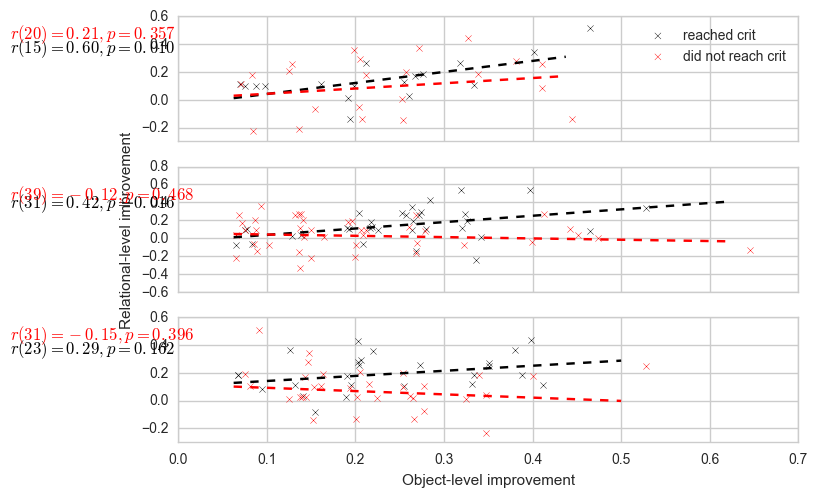

In [52]:
fig,ax = subplots(nrows=3, ncols=1, sharex=True, sharey=False, squeeze=True)
plot_diff(obj_rel_df.query("condition=='random-order'"), ax[0])
ax[0].legend()
ax[1].set_ylabel("Relational-level improvement")
plot_diff(obj_rel_df.query("condition=='label-order'"), ax[1])
plot_diff(obj_rel_df.query("condition=='shape-order'"), ax[2])
ax[2].set_xlabel("Object-level improvement")

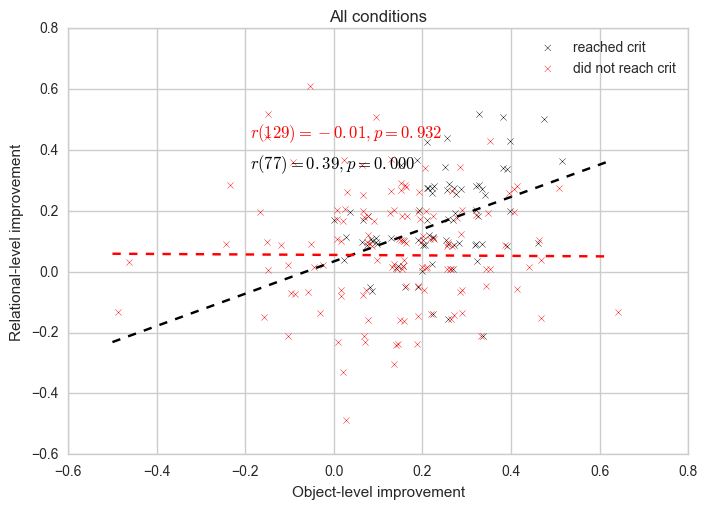

In [23]:
subplot()
plot_diff(obj_rel_df)
title("All conditions")
savefig("images/exp2-corr-rand.pdf")

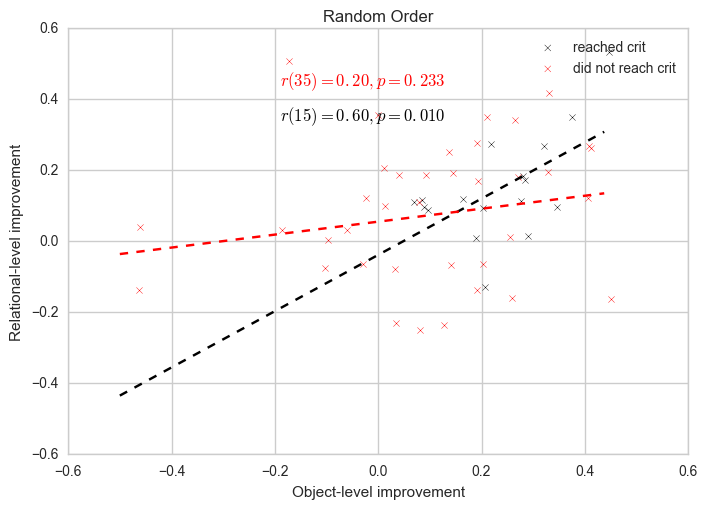

In [24]:
plot_diff(obj_rel_df.query("condition=='random-order'"))
title("Random Order")
savefig("images/exp2-corr-rand.pdf")

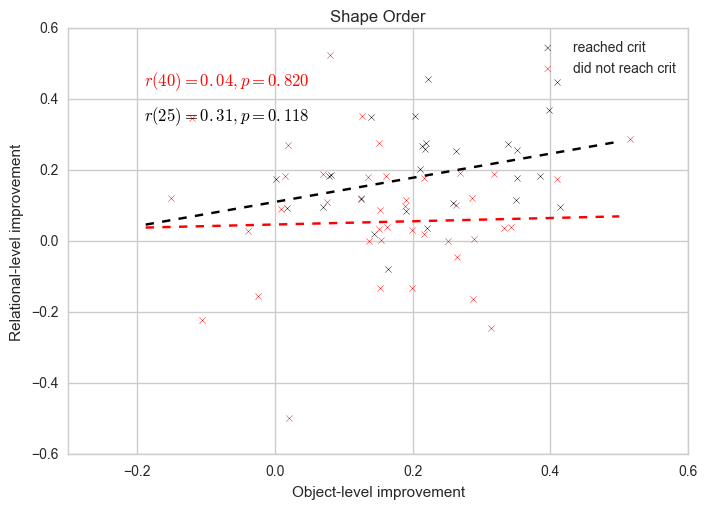

In [25]:
plot_diff(obj_rel_df.query("condition=='shape-order'"))
title("Shape Order")
savefig("images/exp2-corr-rand.pdf")

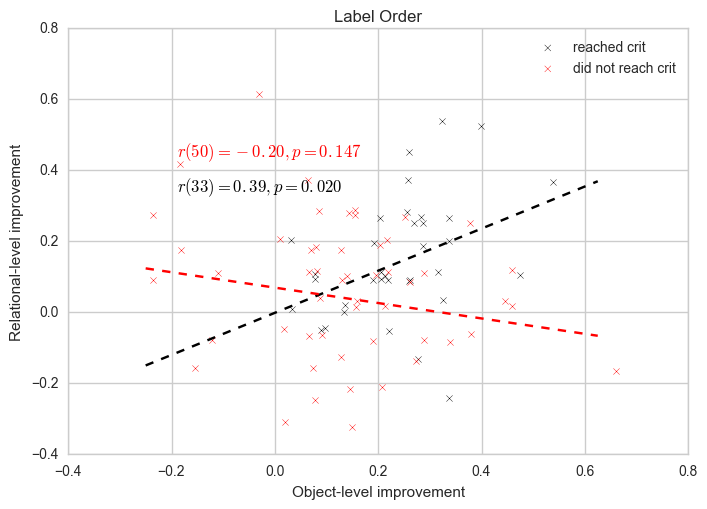

In [26]:
plot_diff(obj_rel_df.query("condition=='label-order'"))
title("Label Order")
savefig("images/exp2-corr-rand.pdf")

# Compare times to criterion



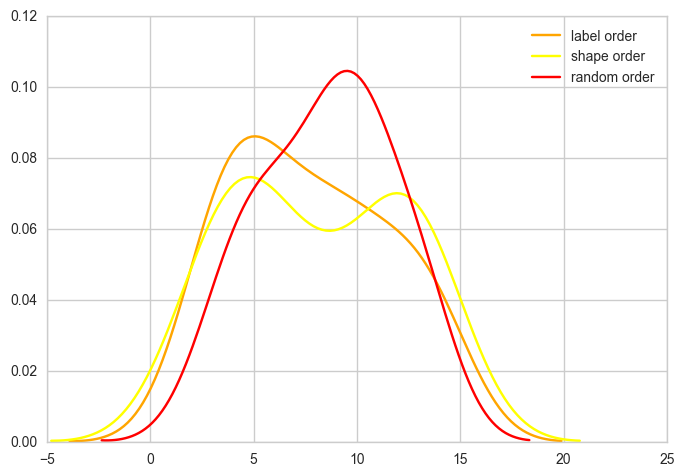

In [27]:
label_order = obj_rel_df.query("condition=='label-order' & reached_crit==True")["crit_block"]
shape_order = obj_rel_df.query("condition=='shape-order' & reached_crit==True")["crit_block"]
random_order = obj_rel_df.query("condition=='random-order' & reached_crit==True")["crit_block"]
seaborn.kdeplot(label_order, color="orange", label="label order")
seaborn.kdeplot(shape_order, color="yellow", label="shape order")
seaborn.kdeplot(random_order, color="red", label="random order")

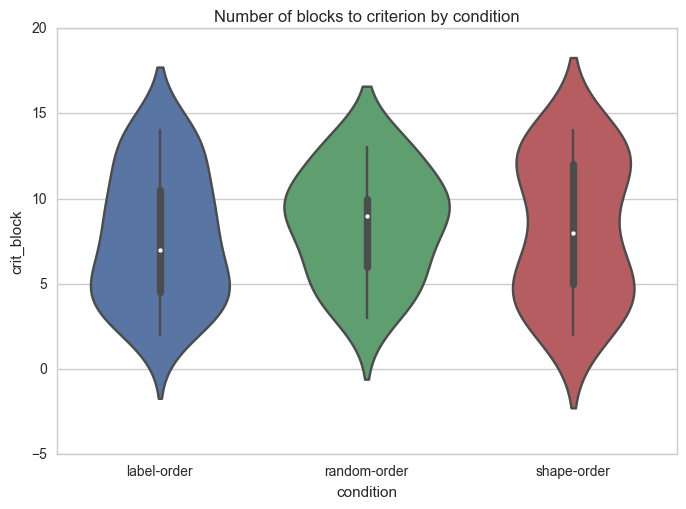

In [28]:
seaborn.violinplot(x="condition", y="crit_block", data=obj_rel_df.query("reached_crit==True"))
title("Number of blocks to criterion by condition")

In [29]:
t_test_text_2samp(obj_rel_df.query("condition=='random-order' & reached_crit==True").crit_block,
                 obj_rel_df.query("condition!='random-order' & reached_crit==True").crit_block)

'x1 (M = 8.5294, SD = 3.1646), x2 (M = 7.9355, SD = 3.9083); t(77) = 0.6498, p = 0.5207, d=0.1577'

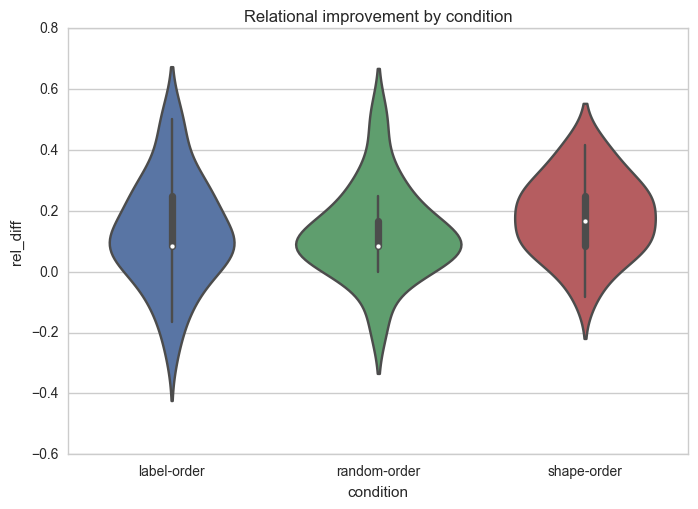

In [58]:
seaborn.violinplot(x="condition", y="rel_diff", data=obj_rel_df.query("reached_crit==True"))
title("Relational improvement by condition")

In [57]:
t_test_text_2samp(obj_rel_df.query("condition=='shape-order' & reached_crit==True").rel_diff,
                 obj_rel_df.query("condition!='shape-order' & reached_crit==True").rel_diff)

'x1 (M = 0.1833, SD = 0.1295), x2 (M = 0.1300, SD = 0.1642); t(73) = 1.5327, p = 0.1307, d=0.3470'

In [ ]:
seaborn.violinplot(x="condition", y="rel_pre", data=obj_rel_df.query("reached_crit==True"))
title("Relational pretest score by condition")

In [ ]:
t_test_text_2samp(obj_rel_df.query("condition=='random-order' & reached_crit==True").rel_pre,
                 obj_rel_df.query("condition!='random-order' & reached_crit==True").rel_pre)

In [ ]:
print(
    "There were {} total subjects, {} of whom reached criterion.".format(
        len(tidy_df.subids.unique()),
        len(tidy_df.query("reached_crit == True").subids.unique())))

In [ ]:
def plot_learning_rate_from_grouped(grouped, color="black", label="", offset=0):
    y = grouped.mean()
    x = array(16-y.index) + offset
    ci = grouped.apply(boot)
    ci = array([list(item) for item in ci])
    ci = abs(ci - y.as_matrix()[:,None])
    errorbar(x=x, y=y, yerr=ci.T, fmt='.', color=color, label=label)
    print(stats.linregress(x=x, y=y))

In [ ]:
figsize(8,8)
incorrect_grouped = tidy_df.query("section == 'training'").groupby("blocks_to_go").incorrect
plot_learning_rate_from_grouped(incorrect_grouped)
ylabel("Error rate")
xlabel("Number of trials remaining")
title("Aggregate learning rate over trials remaining")
tight_layout()
savefig("images/exp2-learning-rate-agg.pdf")

In [ ]:
incorrect_grouped_crit = tidy_df.query("section == 'training' & reached_crit").groupby("blocks_to_go").incorrect
incorrect_grouped_nocrit = tidy_df.query("section == 'training' & (not reached_crit)").groupby("blocks_to_go").incorrect
plot_learning_rate_from_grouped(incorrect_grouped_crit,color="black", label="reached criterion")
plot_learning_rate_from_grouped(incorrect_grouped_nocrit,color="red", label="did not reach criterion", offset=.1)
xticks(arange(16), 16-arange(16))
legend()
ylabel("Error rate")
xlabel("Number of trials remaining")
title("Aggregate learning rate over trials remaining")
tight_layout()
savefig("images/exp2-learning-rate.pdf")

In [ ]:
d = {"one":1, "two":2}
for i in d:
    print(i)

In [ ]:
len([2])